In [12]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [24]:
# Load Data
Simulated_data = np.load(r'C:\Users\Administrator\Desktop\training data\Prospect_Pro_0_0.npy')
real_data = pd.read_csv(r'D:\二学位非软件文件\GREAT\refine_dataset\processed_data.csv')

# Column labels
X_labels = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
Y_labels = ["N", "Cab", "Ccx", "Cw", "Cm"]

# Process Simulated Data
# All_Y_labels = N	cab	car	anth cbrown	cw	cm	cp	cbc	LAI	typeLIDF	LIDF	hspot	psoil	tts	tto	psi	LAIu	cd	sd	h
Y_simulated = np.delete(Simulated_data[:7], [3, 4], axis=0).T
X_simulated = np.delete(Simulated_data[-13:], -3, axis=0).T

# Separate features and labels
X_real = real_data[X_labels].values
Y_real = real_data[Y_labels].values

In [25]:
Y_real

array([[1.31359402e+00, 1.25407820e+01, 4.33000000e+00, 1.22231000e-02,
        5.50680000e-03],
       [1.31359402e+00, 1.25407820e+01, 4.33000000e+00, 1.22231000e-02,
        5.50680000e-03],
       [1.42578515e+00, 1.24136890e+01, 3.65000000e+00, 1.20002800e-02,
        5.25210000e-03],
       ...,
       [2.69461221e+00, 4.44604841e+01, 8.89680790e+00, 7.75109600e-03,
        6.11940400e-03],
       [2.02924315e+00, 3.55345451e+01, 7.06861164e+00, 9.91216000e-03,
        5.16558600e-03],
       [2.38563405e+00, 4.04578762e+01, 7.72907714e+00, 8.03137300e-03,
        6.25824800e-03]])

In [26]:
X_real

array([[ 529.8571429,  815.0769231, 2123.971429 , ..., 4136.952381 ,
        2647.384615 , 1341.563536 ],
       [ 342.2380952,  921.4769231, 2637.857143 , ..., 4990.52381  ,
        3956.164835 , 2797.055249 ],
       [ 592.0952381,  925.6      , 2398.485714 , ..., 4564.619048 ,
        2951.901099 , 1604.342541 ],
       ...,
       [ 824.2261905, 1052.648551 , 1914.3      , ..., 5998.196079 ,
        4334.32     , 2675.363014 ],
       [ 834.4      , 1043.104348 , 1831.952    , ..., 5432.129412 ,
        3546.344    , 2019.153425 ],
       [ 840.2738095, 1065.373188 , 1890.053333 , ..., 5717.803922 ,
        3999.066667 , 2381.257991 ]])

In [27]:
Y_simulated
# Replace NaN values with 0 in Y_aux

array([[1.32073855e+00, 4.77845459e+01, 1.08988752e+01, 6.36326103e-03,
        3.03522125e-03],
       [1.67483687e+00, 7.02134943e+00, 9.34113216e+00, 1.05852373e-02,
        9.55383945e-03],
       [1.77826846e+00, 4.26253738e+01, 9.40113163e+00, 1.26240114e-02,
        3.54332477e-03],
       ...,
       [1.70712566e+00, 4.07472496e+01, 6.04398727e+00, 2.51489878e-03,
        7.81945977e-03],
       [2.12226129e+00, 5.15327797e+01, 6.84975863e+00, 6.18368108e-03,
        4.05708374e-03],
       [1.82345951e+00, 4.82209015e+01, 9.28449917e+00, 5.75728994e-03,
        8.93617887e-03]])

In [28]:
X_simulated

array([[ 194.19569545,  230.43444911,  467.48676734, ..., 5307.84047002,
        3146.05001675, 1371.7734487 ],
       [ 264.76155059,  382.98582155, 1438.94664746, ..., 4715.16212779,
        2853.62554091, 1270.72270691],
       [ 164.66428141,  218.9383878 ,  460.36213009, ..., 3946.42851499,
        1999.4051801 ,  891.21580199],
       ...,
       [ 336.50865584,  451.15728554,  784.89842443, ..., 4840.14601899,
        4227.44022508, 2613.82072261],
       [ 211.16857348,  325.11242384,  641.75567094, ..., 5495.03714114,
        3732.19670591, 1991.74820932],
       [ 181.61572947,  248.33777745,  553.54090387, ..., 5581.94214321,
        3570.31496538, 1764.5613248 ]])

In [42]:
# Data Preprocessing
scaler_X = StandardScaler().fit(X_real) # Fit scaler on the real data
scaler_Y = StandardScaler().fit(Y_real) # Fit scaler on the real data

# Scale both simulated and real data
X_real_scaled = scaler_X.transform(X_real)
Y_real_scaled = scaler_Y.transform(Y_real)

X_simulated_scaled = scaler_X.transform(X_simulated)
Y_simulated_scaled = scaler_Y.transform(Y_simulated)

# Combine Data
real_ratio = 0.8
simulated_ratio = 0.2

X_combined = np.vstack([X_real_scaled * real_ratio, X_simulated_scaled * simulated_ratio])
Y_combined = np.vstack([Y_real_scaled * real_ratio, Y_simulated_scaled * simulated_ratio])
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, Y_combined, test_size=0.2, random_state=42)

In [43]:
X_combined

array([[ 0.40358425,  0.59078702,  0.9618177 , ..., -0.92835321,
        -1.07535857, -0.91889132],
       [-0.12265382,  0.83402908,  1.60389271, ...,  0.38962875,
         0.71427958,  0.83911805],
       [ 0.57815104,  0.84345489,  1.30480984, ..., -0.26800197,
        -0.65895992, -0.60149483],
       ...,
       [-0.03468097, -0.06029329, -0.17782209, ...,  0.03935838,
         0.27130601,  0.15444976],
       [-0.12257013, -0.13233138, -0.22253456, ...,  0.29215933,
         0.10200587, -0.03339214],
       [-0.14329275, -0.17621019, -0.25008956, ...,  0.32570639,
         0.04666623, -0.10199382]])

In [44]:
Y_combined

array([[-0.87557183, -1.25987539, -0.98345378,  0.16207356,  0.00563117],
       [-0.87557183, -1.25987539, -0.98345378,  0.16207356,  0.00563117],
       [-0.60651326, -1.26530312, -1.1097032 ,  0.1296262 , -0.06552978],
       ...,
       [ 0.01705051, -0.01381741, -0.16630834, -0.31291207,  0.16294202],
       [ 0.26594672,  0.10133624, -0.12890828, -0.17934877, -0.09985172],
       [ 0.08679892,  0.06597638, -0.01589925, -0.19487169,  0.24094241]])

In [46]:
# Custom Loss Function with Covariance Penalty
def custom_loss(lam, cov_real_data):
    def loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        cov_pred = tf.linalg.matmul(tf.transpose(y_pred - tf.reduce_mean(y_pred, axis=0)), 
                                    (y_pred - tf.reduce_mean(y_pred, axis=0))) / tf.cast(tf.shape(y_pred)[0], tf.float32)
        cov_penalty = tf.reduce_sum(tf.square(cov_pred - cov_real_data))
        return mse_loss + lam * cov_penalty
    return loss

# Build Model
def build_model(hp, cov_real_data):
    input_features = layers.Input(shape=(X_train.shape[1],), name='input_features')
    x = input_features
    for i in range(hp.Int("num_layers", 2, 12)):
        x = layers.Dense(units=hp.Int("units_" + str(i), 32, 512, step=16), activation="relu")(x)
        x = layers.Dropout(hp.Float("dropout", 0.05, 0.5, step=0.05))(x)
    
    output = layers.Dense(len(Y_labels))(x)
    model = tf.keras.Model(inputs=input_features, outputs=output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 5e-3, sampling="log")),
                  loss=custom_loss(hp.Float("lambda", 1e-6, 1e-2, sampling="log"), cov_real_data),
                  metrics=["mae"])
    
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_mae', patience=7, restore_best_weights=True)

# Compute the covariance matrix of the real world data
cov_real_data = np.cov(Y_real_scaled, rowvar=False)

# Bayesian Optimization
tuner = BayesianOptimization(
    lambda hp: build_model(hp, cov_real_data),
    objective="val_mae",
    max_trials=20,
    num_initial_points=10,
    directory="keras_tuner_directory",
    project_name="ann_tuning_bayesian_pretrain"
)

In [47]:
# Training the model
tuner.search(X_train, y_train, epochs=120, validation_split=0.2, callbacks=[early_stopping])

Trial 20 Complete [00h 00m 26s]
val_mae: 0.175437331199646

Best val_mae So Far: 0.10297217965126038
Total elapsed time: 00h 17m 48s
INFO:tensorflow:Oracle triggered exit


Epoch 1/100
130/130 [==============================] - 2s 8ms/step - loss: 0.1272 - mae: 0.2020 - val_loss: 0.0993 - val_mae: 0.1734
Epoch 2/100
130/130 [==============================] - 1s 6ms/step - loss: 0.0923 - mae: 0.1774 - val_loss: 0.0860 - val_mae: 0.1601
Epoch 3/100
130/130 [==============================] - 1s 6ms/step - loss: 0.0806 - mae: 0.1679 - val_loss: 0.0786 - val_mae: 0.1538
Epoch 4/100
130/130 [==============================] - 1s 6ms/step - loss: 0.0755 - mae: 0.1631 - val_loss: 0.0761 - val_mae: 0.1487
Epoch 5/100
130/130 [==============================] - 1s 7ms/step - loss: 0.0715 - mae: 0.1578 - val_loss: 0.0732 - val_mae: 0.1452
Epoch 6/100
130/130 [==============================] - 1s 7ms/step - loss: 0.0681 - mae: 0.1539 - val_loss: 0.0689 - val_mae: 0.1408
Epoch 7/100
130/130 [==============================] - 1s 7ms/step - loss: 0.0650 - mae: 0.1504 - val_loss: 0.0686 - val_mae: 0.1405
Epoch 8/100
130/130 [==============================] - 1s 6ms/step - 

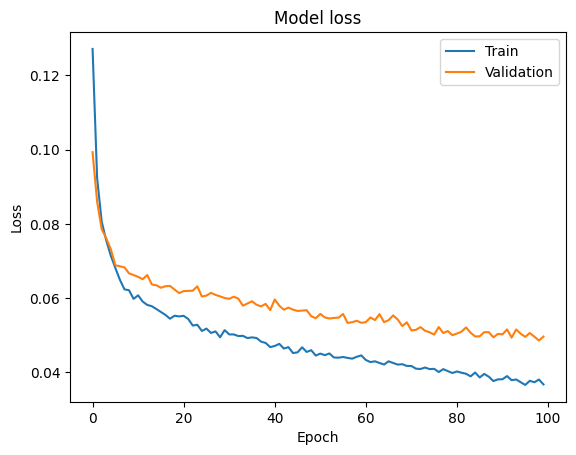

In [48]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
best_model  = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping])

# Evaluate Model
loss, mae = best_model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test MAE:', mae)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [49]:
predictions = best_model.predict(X_test)
errors = predictions - y_test

# 均方误差 (MSE) 和 均方根误差 (RMSE):
# 这两种指标在回归任务中很常见。RMSE 会放大大的误差，因此它对异常值更敏感。如果RMSE的值较大，这意味着模型预测存在较大的误差。
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, RMSE: {rmse}')

# 绝对百分比误差 (MAPE):
# MAPE表示预测误差与真实值的比例。它可以帮助你了解模型预测误差相对于真实值的大小。
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'MAPE: {mape}%')

# R-squared (R²)
# R²是决定系数，表示模型预测的变异与总变异的比例。值为1表示模型预测完美，值为0表示模型的预测与平均值没有区别。
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
print(f'R²: {r2}')

41/41 [==============================] - 0s 2ms/step
MSE: 0.04422063258517402, RMSE: 0.21028702429102472
MAPE: 142.0585689515533%
R²: 0.7818514846920923


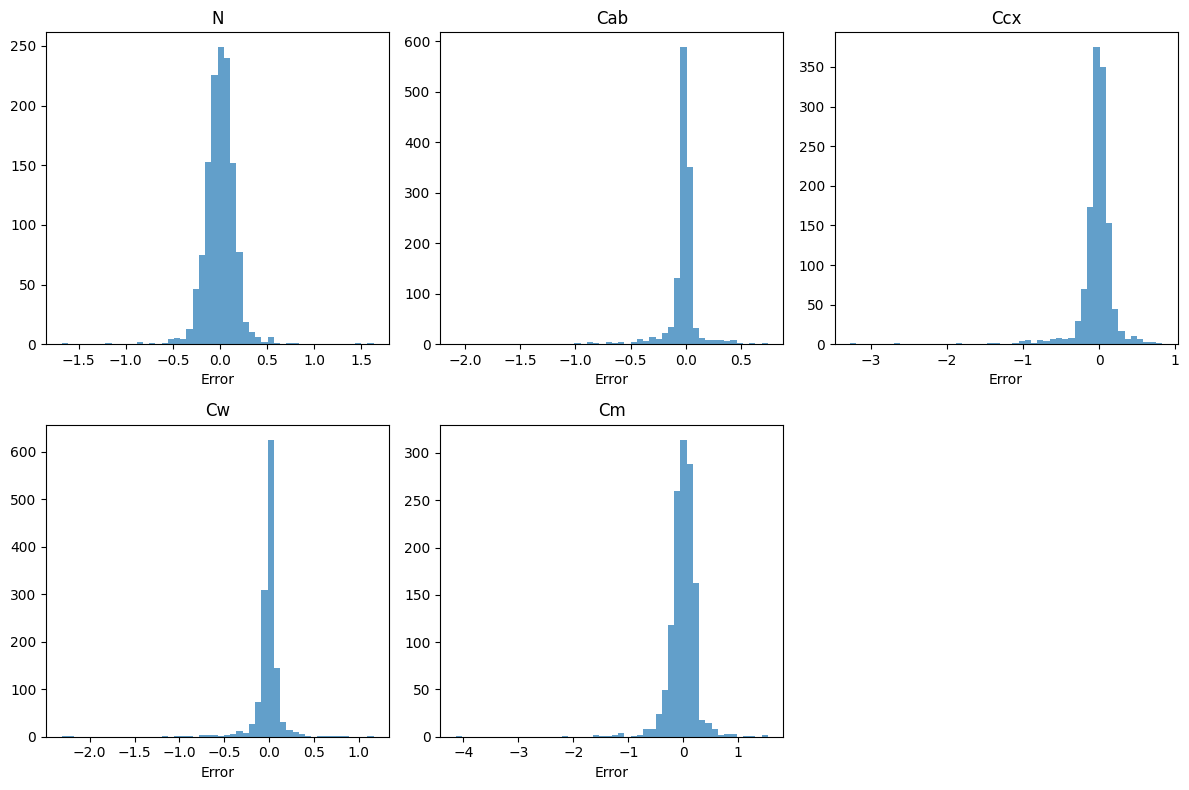

In [50]:
# 6. 绘制误差图
plt.figure(figsize=(12, 8))
for i, label in enumerate(Y_labels):
    plt.subplot(2, 3, i+1)
    plt.hist(errors[:, i], bins=50, alpha=0.7)
    plt.title(label)
    plt.xlabel("Error")
plt.tight_layout()
plt.show()

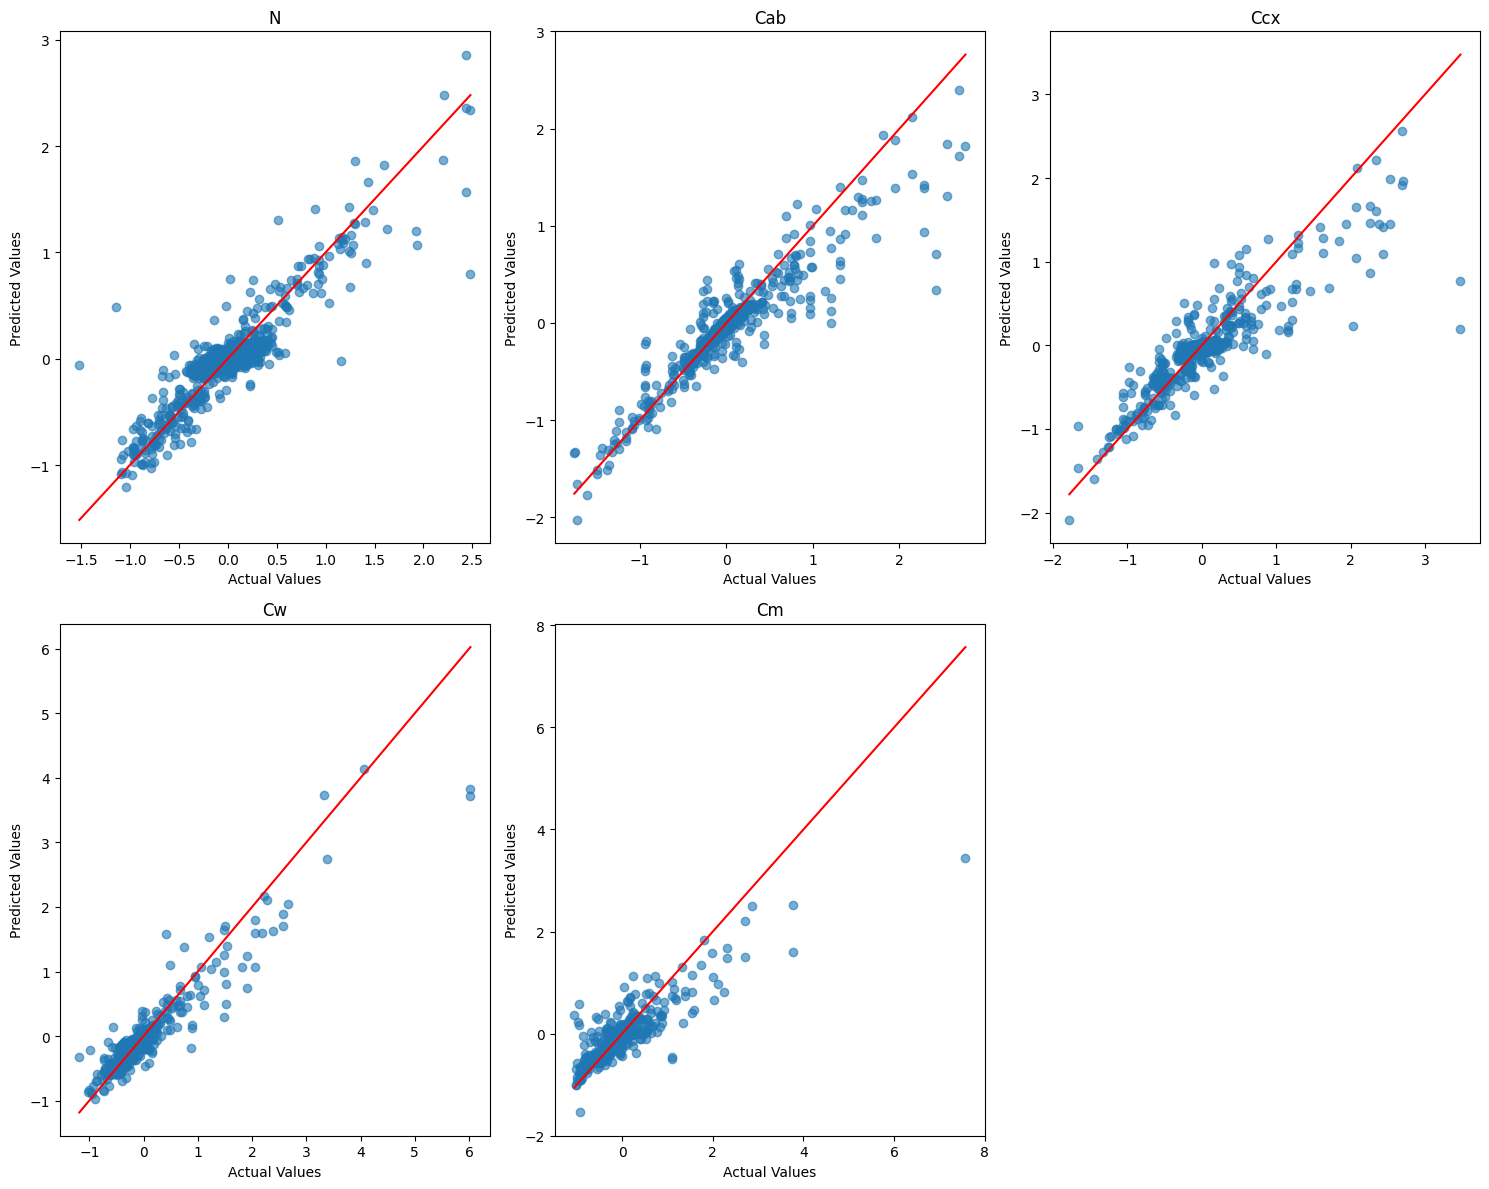

In [51]:
#散点图
plt.figure(figsize=(15, 12))
for i, label in enumerate(Y_labels):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_test[:, i], predictions[:, i], alpha=0.6)
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r')
    plt.title(label)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
plt.tight_layout()
plt.show()

In [39]:
best_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer)  [(None, 12)]             0         
                                                                 
 dense_5 (Dense)             (None, 336)               4368      
                                                                 
 dropout_4 (Dropout)         (None, 336)               0         
                                                                 
 dense_6 (Dense)             (None, 304)               102448    
                                                                 
 dropout_5 (Dropout)         (None, 304)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               156160    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0   

In [52]:
# 保存模型
best_model.save(r"C:\Users\Administrator\Desktop\training data\model\model")
# 保存相关矩阵
np.save(r"C:\Users\Administrator\Desktop\training data\model\cov_real_data.npy", cov_real_data)
# 保存数据预处理器
joblib.dump(scaler_X, r"C:\Users\Administrator\Desktop\training data\model\scaler_X.pkl")
joblib.dump(scaler_Y, r"C:\Users\Administrator\Desktop\training data\model\scaler_y.pkl")

INFO:tensorflow:Assets written to: C:\Users\Administrator\Desktop\training data\model\model\assets


['C:\\Users\\Administrator\\Desktop\\training data\\model\\scaler_y.pkl']